# **1. Importing Library**

In [33]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# **2. Preparing Dataset**

In [34]:
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [35]:
import splitfolders 
splitfolders.ratio("/kaggle/input/agronify-dataset/Ripeness/Ripeness/Tomat", 
                   output="Tomato-data", 
                   seed=42, 
                   ratio=(.7, .2, .1), 
                   group_prefix=None) 


Copying files: 101 files [00:00, 128.78 files/s]


In [36]:
training_dir = os.path.join('Tomato-data', 'train')
testing_dir = os.path.join('Tomato-data', 'test')
validating_dir = os.path.join('Tomato-data', 'val')

# **3. Data Preprocessing**

In [37]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    training_dir,
    shuffle=True,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=8
)

validation_generator = validation_datagen.flow_from_directory(
    validating_dir,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
    batch_size=8
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=8
)

Found 70 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


In [38]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)
class_count = len(class_names)

{'Matang': 0, 'Mentah': 1}
['Matang', 'Mentah']


# **4. Data Preview**

In [39]:
# def display_images(images, labels, class_indices):
#     fig, axes = plt.subplots(4, 4, figsize=(10, 10))
#     axes = axes.ravel()

#     for i, ax in enumerate(axes):
#         ax.imshow(images[i])
#         label_index = np.argmax(labels[i])
#         label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
#         ax.set_title(label)
#         plt.subplots_adjust(wspace=1)
#         ax.axis('off')

# train_images, train_labels = next(train_generator)
# display_images(train_images, train_labels, train_generator.class_indices)
# plt.show()

# **5. Callbacks Function**

In [40]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, total_epochs, ask_epoch):
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.total_epochs = total_epochs
        self.ask = True
        self.lowest_val_loss = np.inf
        self.best_weights = self.model.get_weights()
        self.best_epoch = 1

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.total_epochs:
            print('ask_epoch >= total_epochs, will train for', self.total_epochs, 'epochs', flush=True)
            self.ask = False
        if self.total_epochs == 1:
            self.ask = False
        else:
            print('Training will proceed until epoch', self.ask_epoch, 'then you will be asked to')
            print('enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        print('Loading model with weights from epoch', self.best_epoch)
        self.model.set_weights(self.best_weights)
        training_duration = time.time() - self.start_time
        hours = training_duration // 3600
        minutes = (training_duration - (hours * 3600)) // 60
        seconds = training_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg, flush=True)

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss < self.lowest_val_loss:
            self.lowest_val_loss = val_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f'\nValidation loss of {val_loss:7.4f} is below the lowest loss, saving weights from epoch {str(epoch + 1):3s} as the best weights')
        else:
            print(f'\nValidation loss of {val_loss:7.4f} is above the lowest loss of {self.lowest_val_loss:7.4f}, keeping weights from epoch {str(self.best_epoch)} as the best weights')

        if self.ask:
            if epoch + 1 == self.ask_epoch:
                print('\nEnter H to end training or an integer for the number of additional epochs to run then ask again')
                ans = input()

                if ans.lower() == 'h' or ans == '0':
                    print('You entered', ans, 'Training halted on epoch', epoch + 1, 'due to user input\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.total_epochs:
                        print('\nYou specified a maximum of', self.total_epochs, 'epochs. Cannot train for', self.ask_epoch, flush=True)
                    else:
                        print('You entered', ans, 'Training will continue to epoch', self.ask_epoch, flush=True)
                        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                        print(f'Current learning rate is {current_lr:7.5f}.')

# **6. Selecting Model**

In [41]:
tf.keras.backend.clear_session()
#del model

In [ ]:
# IMAGE_CHANNEL = 3
# IMAGE_SIZE = 224

# model_name = 'MobileNetV3Small'
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)
# base_model = tf.keras.applications.MobileNetV3Small(input_shape=input_shape,
#                                                    include_top=False,
#                                                    weights='imagenet',
#                                                    pooling='max')

# base_model.trainable = True


# **7. Creating Architecture Model**

In [42]:
IMAGE_CHANNEL = 3
IMAGE_SIZE = 224
OUTPUT_SIZE = len(class_names)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),  # Add dropout with a rate of 0.5
    Dense(OUTPUT_SIZE, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

# **8. Training Model**

In [43]:
total_epochs = 50
ask_epoch = 20
ask_callback = LR_ASK(model, total_epochs, ask_epoch)
rlronp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
callbacks = [rlronp_callback, ask_callback]

# **9. Model Validation**

In [44]:
training_history = model.fit(train_generator,
                             epochs=total_epochs,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             shuffle=False,
                             initial_epoch=0)

Training will proceed until epoch 20 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.7557 - accuracy: 0.6000
Validation loss of  0.5226 is below the lowest loss, saving weights from epoch 1   as the best weights
9/9 [==============================] - 31s 3s/step - loss: 0.7557 - accuracy: 0.6000 - val_loss: 0.5226 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8286
Validation loss of  0.0376 is below the lowest loss, saving weights from epoch 2   as the best weights
9/9 [==============================] - 29s 3s/step - loss: 0.3574 - accuracy: 0.8286 - val_loss: 0.0376 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9857
Validation loss of  0.0001 is below the lowest loss, saving weights from epoch

 H


You entered H Training halted on epoch 20 due to user input

9/9 [==============================] - 74s 9s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.3379e-07 - val_accuracy: 1.0000 - lr: 7.8125e-06
Loading model with weights from epoch 7
Training elapsed time was 0.0 hours, 11.0 minutes, 45.40 seconds)


# **10. Model Evaluation**

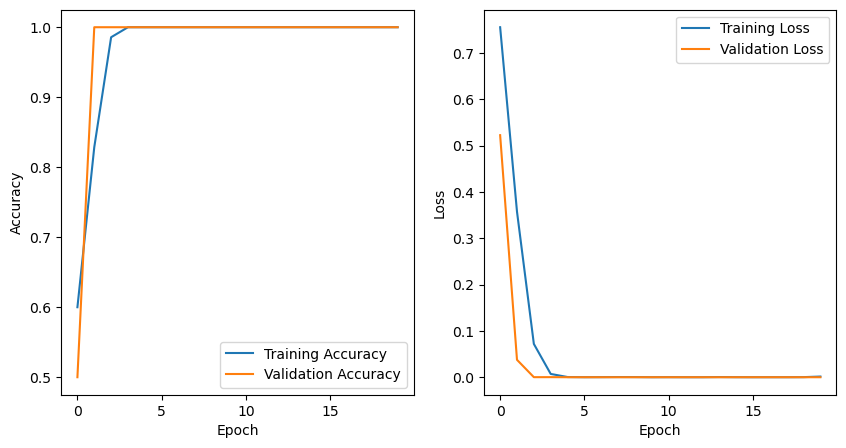

In [45]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [46]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

2/2 [==============================] - 4s 1s/step - loss: 2.7093e-07 - accuracy: 1.0000
Test loss: 2.709301156755828e-07 / Test accuracy: 1.0


# **11. Prediction Test**

# **12. Save Model**

In [47]:
model.save('tomatDeepLearningV2.h5')